# Parte 2 del concurso de detección de clickbait

4. Usar un LLM más robusto, por ejemplo roberta

In [1]:
%pip install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Importar bibliotecas

In [8]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset
import csv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter

## Cargar datasets

In [3]:
df_train = pd.read_csv('TA1C_dataset_detection_train.csv')
df_train = df_train.drop(['Tweet Date', 'Media Name', 'Media Origin'], axis=1)

df_dev = pd.read_csv('TA1C_dataset_detection_dev_gold.csv')
df_dev = df_dev.drop(['Tweet Date', 'Media Name', 'Media Origin'], axis=1)

## Definir datasets de prueba y de dev

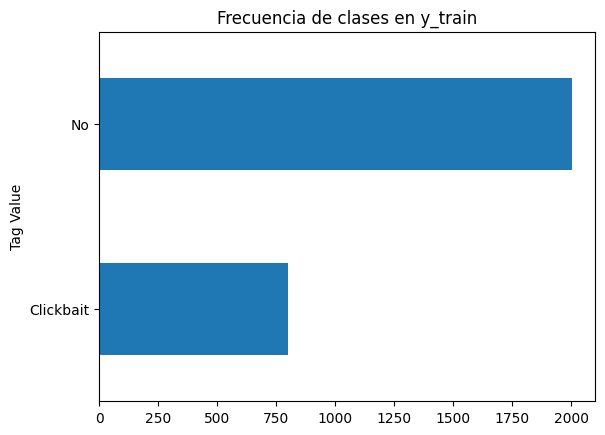

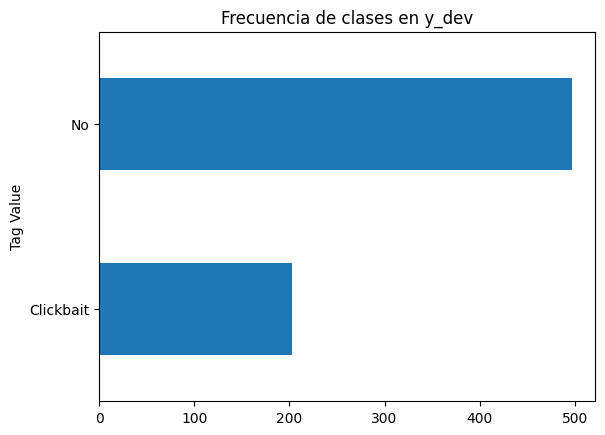

In [4]:
# Separar dataset
X_train = df_train['Teaser Text']
y_train = df_train['Tag Value']

X_dev = df_dev['Teaser Text']
y_dev = df_dev['Tag Value']

le = LabelEncoder()
y_train_labels = le.fit_transform(y_train)
y_dev_labels = le.transform(y_dev)

y_train.value_counts(ascending=True).plot.barh()
plt.title("Frecuencia de clases en y_train")
plt.show()

y_dev.value_counts(ascending=True).plot.barh()
plt.title("Frecuencia de clases en y_dev")
plt.show()


## Carga del modelo

In [9]:
tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
dev_encodings = tokenizer(X_dev.tolist(), truncation=True, padding=True)

class CustomDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings=encodings
    self.labels=labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train_labels)
dev_dataset = CustomDataset(dev_encodings, y_dev_labels)

model = RobertaForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=2)

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="macro")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [11]:
training_args = TrainingArguments(
    output_dir="output",
    eval_strategy="steps",
    eval_steps=100,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: omarveco (omarveco-instituto-polit-cnico-nacional) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1
100,No log,0.288086,0.882857,0.840092
200,No log,0.297387,0.888571,0.871676
300,No log,0.290667,0.918571,0.902391
400,No log,0.333692,0.911429,0.893381
500,0.330400,0.297616,0.918571,0.900399
600,0.330400,0.309785,0.897143,0.878532
700,0.330400,0.369235,0.895714,0.862255
800,0.330400,0.331723,0.915714,0.898683
900,0.330400,0.434540,0.905714,0.881196
1000,0.112200,0.386218,0.905714,0.884500


TrainOutput(global_step=1050, training_loss=0.2132401146207537, metrics={'train_runtime': 192.9024, 'train_samples_per_second': 43.545, 'train_steps_per_second': 5.443, 'total_flos': 474833232720000.0, 'train_loss': 0.2132401146207537, 'epoch': 3.0})

## Predicción en el conjunto de prueba

### Cargar dataset de testeo

In [12]:
df_test = pd.read_csv('TA1C_dataset_detection_dev_gold.csv')
df_test = df_test.drop(['Tweet Date', 'Media Name', 'Media Origin'], axis=1)

X_test = df_test['Teaser Text']
y_test = df_test['Tag Value']

test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
y_test_labels = le.transform(y_test)

test_dataset = CustomDataset(test_encodings, y_test_labels)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)

predicted_classes = np.argmax(predictions.predictions, axis=1)

report = classification_report(y_test_labels, predicted_classes)

print(report)


              precision    recall  f1-score   support

           0       0.86      0.82      0.84       203
           1       0.93      0.95      0.94       497

    accuracy                           0.91       700
   macro avg       0.90      0.88      0.89       700
weighted avg       0.91      0.91      0.91       700



In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Matriz de confusión normalizada")
  plt.show()

[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 

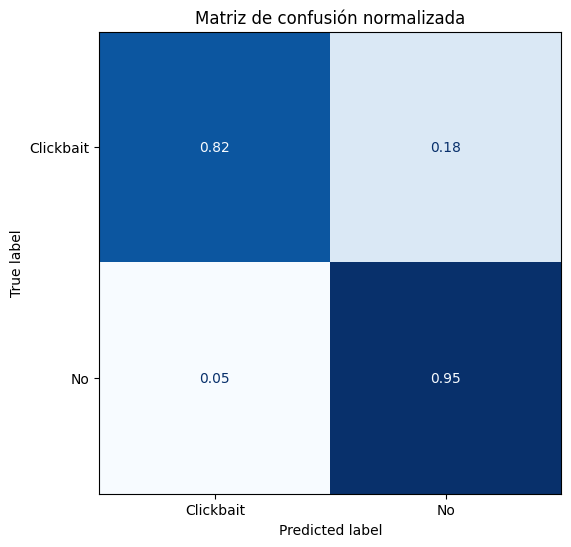

In [15]:
import numpy as np

label_name = np.unique(df_test['Tag Value'])
y_test = y_test_labels.tolist()
print(y_test)
plot_confusion_matrix(predicted_classes, y_test, label_name)